In [22]:
import nilearn
import nibabel as nib

import os
import pandas as pd
import numpy as np
import nibabel as nib
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#from jupyterthemes import jtplot
#jtplot.style('onedork')

from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiMapsMasker
from nilearn.image import concat_imgs, index_img, mean_img, math_img
from nilearn._utils import check_niimg
%matplotlib inline

In [23]:
def get_fn(sub, ses, run=1, echo_n=None, combmode=None, denoised=False,
           root_dir='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep'):
    if not isinstance(sub, str):
        sub = str(sub).zfill(2)

    if ses == 'se':
        hdr = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run))
        mask = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
    elif ses == 'me':
        mask = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
        if echo_n is None and combmode is not None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold_lcat-den.nii.gz'.format(sub, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-{}_bold.nii.gz'.format(sub, sub, run, combmode))
        elif echo_n is not None and combmode is None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz'.format(sub, echo_n, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run, echo_n))

        else:
            raise(IOError('Requires either combmode or echo_n'))
    
    return hdr, mask

def make_tSNR_map(sub, ses, run=1, echo_n=None, combmode=None, denoised=False, save=True, overwrite=False):
    for run in [1,2,3]:
        hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
        output_fn = hdr_fn.replace("_bold", "_tsnr")
        if os.path.exists(output_fn) and not overwrite:
            continue
        
        hdr = nib.load(hdr_fn)
        data = hdr.get_data()
        sig = np.mean(data, axis=3)
        noise = np.std(data, axis=3)
        tsnr = sig/noise
        
        tsnr[tsnr<0] = 0    # = np.clip(tsnr, a_min=0, a_max=250)
        tsnr[tsnr>250] = 0  # extremely high tsnrs occur due to the absence of signal: the temporal std is then (near) 0.
        
        mask = nib.load(mask_fn).get_data()
        sig[mask==0] = 0
        noise[mask==0] = 0
        tsnr[mask==0] = 0
        
        sig = nib.Nifti1Image(sig, affine=hdr.affine)
        noise = nib.Nifti1Image(noise, affine=hdr.affine)
        tsnr = nib.Nifti1Image(tsnr, affine=hdr.affine)
        
        output = concat_imgs([tsnr, sig, noise])
        nib.save(output, output_fn)
        print(output_fn)
    return 0

# Calculate voxel-wise tSNR
Create tSNR-maps first, then calculate the mean tSNR over voxels within a mask (weighted by probability)

In [24]:
import multiprocessing as mp
from functools import partial
import itertools
subs = [x for x in np.arange(1, 19) if not x == 12]
ses = ['se', 'optcomb', 1, 2, 3]
to_run = list(itertools.product(subs, ses))
# to_run

In [25]:
def mp_helper(to_run, overwrite=False):
    sub, ses = to_run
    
    if ses == 'se':
        make_tSNR_map(sub, ses, overwrite=overwrite)
    elif ses == 'optcomb':
        make_tSNR_map(sub, ses='me', combmode='optcomb', overwrite=overwrite)
    else:
        make_tSNR_map(sub, ses='me', echo_n=ses, overwrite=overwrite)
        
with mp.Pool(15) as p:
    p.map(partial(mp_helper, overwrite=False), to_run)

# Calculate voxel-wise theoretical CNR
(Gowland & Bowtell, 2007; Poser et al., 2006; Posse et al, 1999)

For single echo: 

$CNR = \frac{S\cdot TE}{\sigma}$

For multi echo:

$C = w \cdot S \cdot TE$

$\sigma = std(combined)$

In [26]:
def make_CNR_map(sub, ses, echo_n=None, combmode=None, denoised=False, save=True,
                 tes_me = [0.00966, 0.02487, 0.04008], te_se = 0.014, overwrite=False):
    for run in [1,2,3]:
        if (ses == 'se') or (ses == 'me' and echo_n is not None):
            hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
            tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
            out_fn = hdr_fn.replace('_bold', '_cnr')
            if os.path.exists(out_fn) and not overwrite:
                continue

            if echo_n is not None:
                te = tes_me[echo_n-1]
            else:
                te = te_se
            cnr = index_img(tsnr_fn, 0).get_data()*te
            cnr[cnr<0] = 0
            cnr = nib.Nifti1Image(cnr, affine=nib.load(hdr_fn).affine)
            # save
            nib.save(cnr, out_fn)
        elif ses == 'me' and combmode == 'optcomb':
            # get noise term
            hdr_fn, mask_fn = get_fn(sub, 'me', run=run, echo_n=None, combmode='optcomb')
            tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
            out_fn = hdr_fn.replace('_bold', '_cnr')
            if os.path.exists(out_fn) and not overwrite:
                continue

            # get contrasts
            echos = [get_fn(sub, 'me', echo_n=x, run=run)[0] for x in [1,2,3]]
            echos_contrast = [mean_img(echos[x-1]).get_data()*tes_me[x-1] for x in [1,2,3]]

            # load t2s-map
            t2s = nib.load('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-t2svG_bold.nii.gz'.format(str(sub).zfill(2), str(sub).zfill(2), run))
            t2s_dat = t2s.get_data()

            # get weights (optcomb method)
            weights = [tes_me[x-1]*np.exp(-tes_me[x-1]/t2s_dat) for x in [1,2,3]]
            weights_normalized = weights/np.sum(np.array(weights), axis=0)

            # weight each individual contrast
            echos_weighted = [echos_contrast[x]*weights_normalized[x,:,:,:] for x in [0,1,2]]        
            contrast = np.sum(np.array(echos_weighted), axis=0)

            noise = index_img(nib.load(tsnr_fn), 2)
            cnr = nib.Nifti1Image(contrast / noise.get_data(), affine=t2s.affine)
            nib.save(cnr, out_fn)
            # save
    return 0

In [27]:
def mp_helper(to_run, **kwargs):
    sub, ses = to_run
#     print('{} {}'.format(sub, ses))
    if ses == 'se':
        make_CNR_map(sub, ses, **kwargs)
    elif ses == 'optcomb':
        make_CNR_map(sub, ses='me', combmode='optcomb', **kwargs)
    else:
        make_CNR_map(sub, ses='me', echo_n=ses, **kwargs)
        
with mp.Pool(15) as p:
    p.map(partial(mp_helper, overwrite=False), to_run)

## Utility functions for further analysis

In [28]:
from utils import *
atlas = load_atlas()

def get_fn_short(sub, ses=None, run=1, output_type='tsnr'):
    if ses == 'se':
        bold = get_fn(sub, 'se', run=run)[0]
    elif ses == 'optcomb':
        bold = get_fn(sub, ses='me', combmode=ses, run=run)[0]
    else:
        bold = get_fn(sub, ses='me', echo_n=ses[-1], run=run)[0]
    
    if output_type == 'tsnr':
        return bold.replace('_bold', '_tsnr')
    elif output_type == 'cnr':
        return bold.replace('_bold', '_cnr')

def get_roi_values(nii, atlas):
    data = nii.get_data()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 1000) | np.isnan(data)
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]
        this_mask = index_img(atlas.maps, mask_id).get_data()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        
        val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        out[mask_label] = val_weighted
    return out

def _make_fn_df(output_type='tsnr'):
    subs = [str(x).zfill(2) for x in np.arange(1, 19) if not x == 12]
    runs = [1,2,3]
    data_types = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
    index = pd.MultiIndex.from_product([subs, data_types, runs], names=['subject', 'data_type', 'run'])
    fn_df = pd.DataFrame(index=index, columns=['fn'])
    fn_df['fn'] = fn_df.reset_index().apply(lambda x: get_fn_short(x['subject'], x['data_type'], x['run'], output_type=output_type), axis=1).values
    
    # check if all niis exist, load only those that exist
    fn_df['exists'] = fn_df['fn'].apply(os.path.exists)
    fn_df = fn_df[fn_df['exists']]
    if output_type == 'tsnr':
        fn_df['nii'] = fn_df['fn'].apply(lambda x: index_img(x, 0)) # don't forget to index: first is the tSNR
    else:
        fn_df['nii'] = fn_df['fn'].apply(nib.load)
    return fn_df

def get_subjectwise_rois(output_type='tsnr', atlas=atlas):
    fn_df = _make_fn_df(output_type=output_type)
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    roiwise_df = means_across_runs.apply(get_roi_values, atlas=atlas)
    return roiwise_df

def get_wholebrain_niis(output_type='tsnr'):
    fn_df = _make_fn_df(output_type=output_type)
    
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    
    # and across subs
    means_across_subs = means_across_runs.reset_index().groupby('data_type').apply(lambda x: mean_img(x[0]))    
    
    return means_across_subs

## tSNR analysis

In [29]:
subjectwise_tsnrs = get_subjectwise_rois('tsnr')

In [30]:
index_order = ['Single echo', 'Multi echo combined', 'Echo 1', 'Echo 2', 'Echo 3']
column_order = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN', 'lSTN']

In [134]:
roiwise_tsnr = subjectwise_tsnrs.groupby(level=[0]).mean()[column_order]
roiwise_tsnr = roiwise_tsnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr.index.name = 'Data type'
roiwise_tsnr = roiwise_tsnr.reindex(index = index_order)
roiwise_tsnr.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,89.69,86.48,81.30,71.94,55.26,58.40,59.70,59.01
Multi echo combined,60.23,60.25,58.03,43.47,31.54,32.53,34.58,34.85
Echo 1,71.68,66.88,65.70,44.78,32.03,32.36,34.55,34.81
Echo 2,40.43,42.07,39.46,23.10,10.89,12.46,14.30,14.58
Echo 3,24.86,27.52,24.03,12.27,5.55,6.47,6.16,6.20


In [194]:
from matplotlib.colorbar import ColorbarBase
from matplotlib import colors
import matplotlib
our_cmap = plotting.cm.cold_hot

Text(0.19, 0.48, 'test')

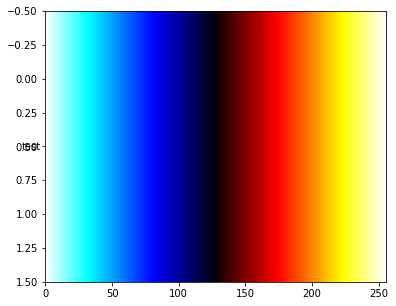

In [195]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, axes = plt.subplots(nrows=1)
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)

#for ax, name in zip(axes, cmap_list):
axes.imshow(gradient, aspect='auto', cmap=our_cmap)
pos = list(axes.get_position().bounds)
x_text = pos[0] - 0.01
y_text = pos[1] + pos[3]/2.
fig.text(x_text, y_text, 'test', va='center', ha='right', fontsize=10)

# Turn off *all* ticks & spines, not just the ones with colormaps.
# axes.set_axis_off()

In [196]:
def get_x(tsnr, tsnr_max=150, vmax=256):
    return int(vmax/2 + (tsnr/tsnr_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap):
    x = get_x(tsnr)
    rgb = cmap(x)[:3]
    return matplotlib.colors.rgb2hex(rgb)

color_table = roiwise_tsnr.copy()
for row in range(roiwise_tsnr.shape[0]):
    for col in range(roiwise_tsnr.shape[1]):
#         print(roiwise_tsnr.iloc[row, col])
        x = get_hex(roiwise_tsnr.iloc[row, col], cmap=our_cmap)
        color_table.iloc[row, col] = x

color_table.iloc[:,:-1]
# roiwise_tsnr.apply(get_hex, cmap=our_cmap)
#get_hex(roiwise_tsnr., cmap=our_cmap)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
Data type,,,,,,,
Single echo,#ff9d00,#ff8e00,#ff7900,#ff4f00,#ff0500,#ff1000,#ff1500
Multi echo combined,#ff1a00,#ff1a00,#ff1000,#cf0000,#960000,#9b0000,#a50000
Echo 1,#ff4f00,#ff3a00,#ff3400,#d50000,#9b0000,#9b0000,#a50000
Echo 2,#c00000,#c50000,#ba0000,#710000,#3c0000,#420000,#4c0000
Echo 3,#7b0000,#860000,#760000,#420000,#220000,#270000,#270000


In [32]:
roiwise_tsnr_std = subjectwise_tsnrs.groupby(level=[0]).std()[column_order]
roiwise_tsnr_std = roiwise_tsnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr_std.index.name = 'Data type'
roiwise_tsnr_std = roiwise_tsnr_std.reindex(index = index_order)
roiwise_tsnr_std.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,15.32,13.45,15.46,10.90,9.63,8.89,8.22,8.23
Multi echo combined,8.66,7.69,9.13,4.27,3.68,4.19,3.47,3.35
Echo 1,7.33,6.62,7.81,4.00,3.84,4.34,4.12,3.88
Echo 2,4.27,4.52,5.60,2.79,1.56,1.90,1.62,1.36
Echo 3,2.90,3.63,3.87,1.85,0.60,0.80,0.73,0.78


In [33]:
wholebrain_tsnr = get_wholebrain_niis()

In [34]:
stat_maps_tsnr = wholebrain_tsnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values
len(stat_maps_tsnr)

5

In [35]:
templt = nib.load('/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')
black_bg = templt.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=templt.affine)

In [36]:
########## Plotting functions
def plot_spm2(zmaps, roi_dict, bg_img=None, z_threshold=0, f=None, axes=None,
             # brain_mask='../Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c.nii.gz',
             roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN'),
             cut_coords=[None, None, None, None, None, None, None, None],
             contrasts=('failed_stop - go_trial',
                        'successful_stop - go_trial',
                        'failed_stop - successful_stop'),
             plot_columns=(0, 1, 3, 4, 6, 7),
             empty_plots=False, skip_all_but_last=False,
             **kwargs):
    
    if f is None:
        gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1])
        f, axes = plt.subplots(len(roi_to_plot), len(zmaps)+3, gridspec_kw=gridspec)  # add 3 columns: 2 interspace, 1 on the right for the colorbar
 
    if empty_plots:
        f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
        return f, axes
    
    # keep track of cut_coordinates and of all displays created
    all_cut_coords = []
    all_disps = []
    
    # loop over rows (= target ROIs)
    for row_n, roi in enumerate(roi_to_plot):
        # for debugging
        if skip_all_but_last:
            if row_n < (len(roi_to_plot)-1):
                continue
        
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict['l' + roi]
        else:
            roi_map = roi_dict[roi]
            
        # find cut coordinates, determine display mode (x/y/z)
        if roi == 'rIFG':
            ## saggital
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[0:1]
            else:
                this_cut_coords = cut_coords[row_n]
            display_mode='x'
            plot_rois = ['rIFG', 'M1', 'rPreSMA']
        elif roi == 'STR':
            ## axial view
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[2:3]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='z'
            plot_rois = ['rIFG',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN']
        elif roi == 'STN':
            ## coronal view
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[1:2]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='y'
            plot_rois = ['rIFG',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN']

        all_cut_coords.append({display_mode: this_cut_coords[0]})
        
        # loop over contrasts for columns
        for col_n, map_n in zip(plot_columns, np.arange(len(zmaps))):
            zmap = zmaps[map_n]
            if skip_all_but_last:
                if col_n < (len(zmaps)-1):
                    continue
            
            if row_n == (len(roi_to_plot)-1) and col_n == (len(zmaps)-1):
                # plot colobar in the last plot
                cbar = False
            else:
                cbar = False
            
#             # do not plot in column 2 or 5
#             plot_col = col_n
#             if col_n > 1:
#                 plot_col = col_n + 1
#             if col_n > 3:
#                 plot_col = col_n + 2
                
            if isinstance(z_threshold, list):
                this_threshold = z_threshold[map_n]
            else:
                this_threshold = z_threshold
            ax = axes[row_n, col_n]
            
            # plot stat map
            disp = plotting.plot_stat_map(zmap, bg_img=bg_img, 
                                          threshold=this_threshold, cut_coords=this_cut_coords,
                                          display_mode=display_mode, axes=ax, colorbar=cbar, **kwargs)
        
            # Add contours for rois
            for roi_ in plot_rois:
                roi_map = roi_dict[roi_]
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
            
            # determine limits (xlim/ylim) based on first column, and apply to all others
            this_key = list([x for x in disp.axes.keys()])[0]
            # Determine new xlim/ylim based on first column
            if col_n == plot_columns[0]:
                # extract old/current limits
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                if display_mode == 'x':
                    new_xlim = get_prop_limits([0, 1], cur_xlim)
                    new_ylim = get_prop_limits([0, 1], cur_ylim)
                elif display_mode == 'z' and 'STN' in roi:            
                    new_xlim = get_prop_limits([.25, .75], cur_xlim)
                    new_ylim = get_prop_limits([.40, .90], cur_ylim)
                elif display_mode == 'z' and 'STR' in roi:
                    new_xlim = get_prop_limits([0, 1], cur_xlim)
                    new_ylim = get_prop_limits([0.3, 1], cur_ylim)
                elif display_mode == 'y':
                    new_xlim = get_prop_limits([.26, .74], cur_xlim)
                    new_ylim = get_prop_limits([.25, .75], cur_ylim)

            # Change axes limits
            disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
            disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            
            all_disps.append(disp)

    # add labels
    if not skip_all_but_last:
        for row_n, ax in enumerate(axes[:,0]):
            cc = all_cut_coords[row_n]
            disp_mode = [x for x in cc.keys()][0]
            coord = cc[disp_mode]
            ax.annotate('%s = %d' %(disp_mode, int(coord)), 
                        xy=(0, 0.5), 
                        xytext=(-ax.yaxis.labelpad - 0.5, 0),
                        xycoords=ax.yaxis.label, 
                        textcoords='offset points', rotation=90,
                        size=16, ha='right', va='center')
#             ax.set_ylabel('%s = %d' %(disp_mode, int(coord)), labelpad=30, size=16)

    f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
    
    return f, axes, all_disps



/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotli

Text(0.5, 1.0, 'tSNR')

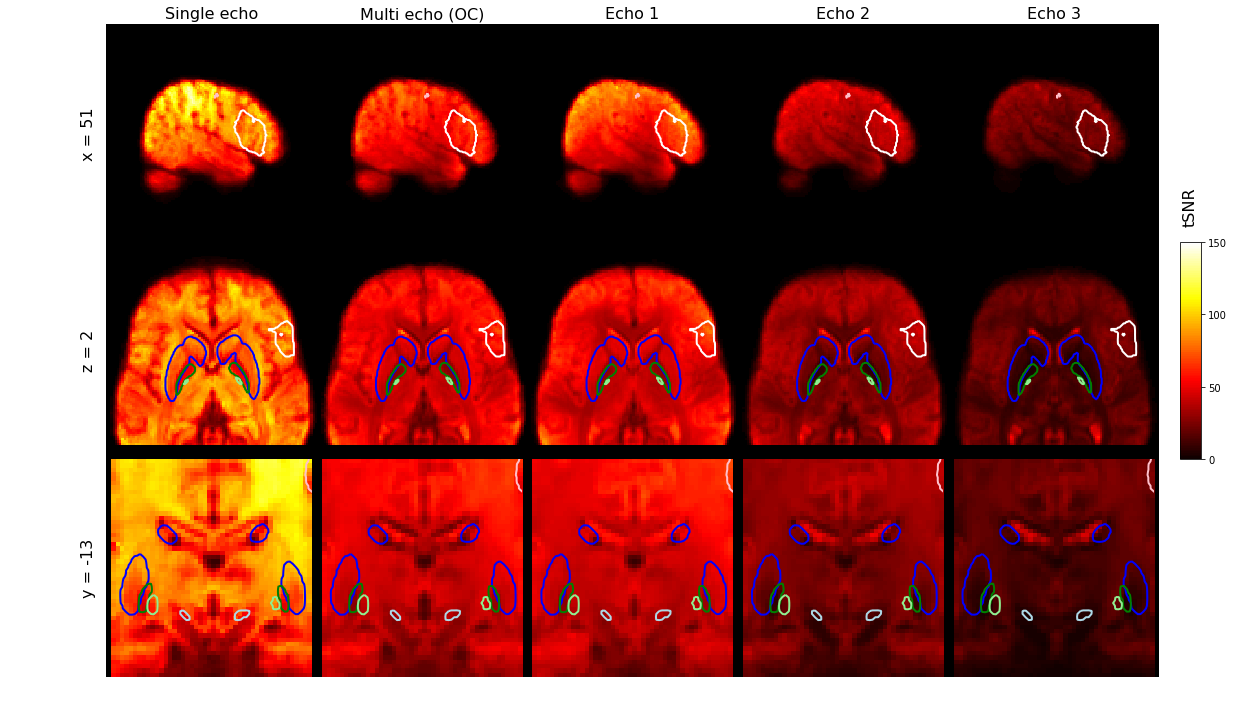

In [37]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps_tsnr)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps_tsnr)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps_tsnr, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=black_bg,
                          vmax=150, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo (OC)', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Positions
axes[0,0].set_ylabel('x = 51', labelpad=24, size=16)
axes[1,0].set_ylabel('y = 2', labelpad=24, size=16)
axes[2,0].set_ylabel('z = -13', labelpad=24, size=16)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=150, truncation_limits=(0,150), offset=0, flip=False)
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('tSNR', rotation=90, fontsize=16, ha='center', va='bottom', pad=16)

### CNR analysis

In [17]:
subjectwise_cnrs = get_subjectwise_rois('cnr')

In [18]:
roiwise_cnr = subjectwise_cnrs.groupby(level=[0]).mean()[column_order]
roiwise_cnr = roiwise_cnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr.index.name = 'Data type'
roiwise_cnr = roiwise_cnr.reindex(index = index_order)
roiwise_cnr.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,1.30,1.22,1.15,1.01,0.77,0.82,0.84,0.83
Multi echo combined,1.33,1.40,1.28,0.81,0.46,0.51,0.53,0.54
Echo 1,0.69,0.65,0.63,0.43,0.31,0.31,0.33,0.34
Echo 2,1.01,1.05,0.98,0.57,0.27,0.31,0.36,0.36
Echo 3,1.00,1.10,0.96,0.49,0.22,0.26,0.25,0.25


In [197]:
def get_x(tsnr, tsnr_max=2, vmax=256):
    return int(vmax/2 + (tsnr/tsnr_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap):
    x = get_x(tsnr)
    rgb = cmap(x)[:3]
    return matplotlib.colors.rgb2hex(rgb)

color_table = roiwise_cnr.copy()
for row in range(roiwise_cnr.shape[0]):
    for col in range(roiwise_cnr.shape[1]):
#         print(roiwise_tsnr.iloc[row, col])
        x = get_hex(roiwise_cnr.iloc[row, col], cmap=our_cmap)
        color_table.iloc[row, col] = x

color_table.iloc[:,:-1]
# roiwise_tsnr.apply(get_hex, cmap=our_cmap)
#get_hex(roiwise_tsnr., cmap=our_cmap)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
Data type,,,,,,,
Single echo,#ffc200,#ffa200,#ff8e00,#ff5e00,#ff1000,#ff1f00,#ff2500
Multi echo combined,#ffcc00,#ffe100,#ffb700,#ff1a00,#a50000,#b50000,#ba0000
Echo 1,#f40000,#e40000,#df0000,#9b0000,#710000,#760000,#7b0000
Echo 2,#ff5e00,#ff6900,#ff5400,#ca0000,#660000,#710000,#810000
Echo 3,#ff5900,#ff7e00,#ff4f00,#b00000,#570000,#610000,#5c0000


In [198]:
roiwise_cnr_std = subjectwise_cnrs.groupby(level=[0]).std()[column_order]
roiwise_cnr_std = roiwise_cnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr_std.index.name = 'Data type'
roiwise_cnr_std = roiwise_cnr_std.reindex(index = index_order)
roiwise_cnr_std.round(2).iloc[:,:-1]

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
Data type,,,,,,,
Single echo,0.22,0.19,0.22,0.15,0.13,0.12,0.12
Multi echo combined,0.18,0.18,0.20,0.09,0.05,0.07,0.05
Echo 1,0.07,0.06,0.08,0.04,0.04,0.04,0.04
Echo 2,0.11,0.11,0.14,0.07,0.04,0.05,0.04
Echo 3,0.12,0.15,0.16,0.07,0.02,0.03,0.03


In [20]:
wholebrain_cnr = get_wholebrain_niis('cnr')
stat_maps_cnr = wholebrain_cnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values
len(stat_maps_cnr)

5

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotli

Text(0.5, 1.0, 'CNR')

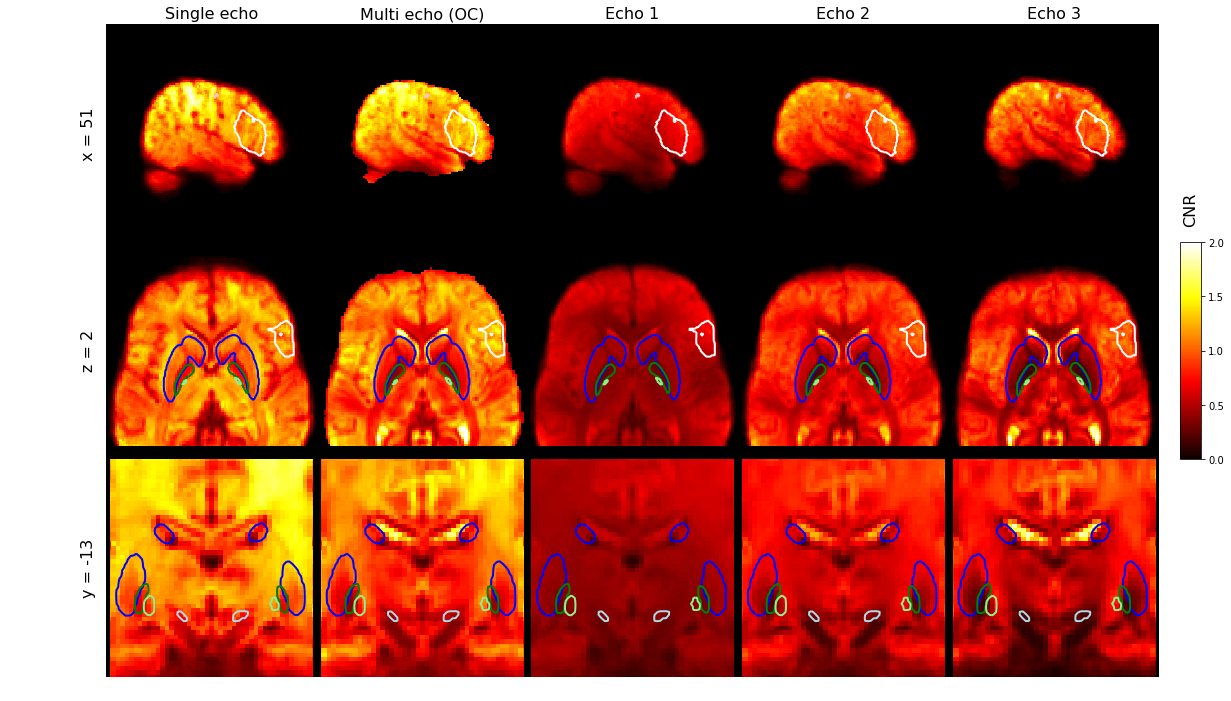

In [21]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps_cnr)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps_cnr)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm2(stat_maps_cnr, roi_dict=get_roi_dict(), 
                           z_threshold=0.01,
                           f=f, axes=axes,
                           roi_to_plot=['rIFG', 'STR', 'STN'],
                           cut_coords=[[51], [2], [-13]],
                           bg_img=black_bg,
                           vmax=2, #colorbar=False, 
                           plot_columns=(0, 1, 2, 3, 4),
                           annotate=False, empty_plots=False, 
                           skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo (OC)', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Positions
axes[0,0].set_ylabel('x = 51', labelpad=24, size=16)
axes[1,0].set_ylabel('z = 2', labelpad=24, size=16)
axes[2,0].set_ylabel('y = -13', labelpad=24, size=16)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=2, truncation_limits=(0,2), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('CNR', rotation=90, fontsize=16, ha='center', va='bottom', pad=16)